Importing Libraries

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader

Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
csv_path = "/content/drive/MyDrive/prep2_train.csv"

In [4]:
df = pd.read_csv(csv_path)
df["polarization"] = df["polarization"].astype(int)

Train Split

In [5]:
train_data, val_data = train_test_split(df, test_size=0.1, random_state=42)

Tokenizer Loading

In [31]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Load the Model

In [32]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dataset Class

In [8]:
class PolarDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.texts = df["text"].tolist()
        self.labels = df["polarization"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = PolarDataset(train_data, tokenizer)
val_dataset = PolarDataset(val_data, tokenizer)

Metrics and Trainging Arguments

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

training_args = TrainingArguments(
    output_dir="./model",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,

    logging_dir="./logs",
    logging_steps=50,
    report_to=[],

    eval_strategy="epoch",
    save_strategy="epoch",

    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,

    fp16=True
)

Trainer

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

Training

In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.428500,0.573550,0.757426,0.747748,0.798077,0.772093
2,0.404100,0.880802,0.747525,0.801136,0.677885,0.734375
3,0.289000,1.105040,0.745050,0.766497,0.725962,0.745679


TrainOutput(global_step=1365, training_loss=0.398114134540488, metrics={'train_runtime': 407.0533, 'train_samples_per_second': 26.797, 'train_steps_per_second': 3.353, 'total_flos': 1435007695933440.0, 'train_loss': 0.398114134540488, 'epoch': 3.0})

Results

In [34]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.5735504627227783, 'eval_accuracy': 0.7574257425742574, 'eval_precision': 0.7477477477477478, 'eval_recall': 0.7980769230769231, 'eval_f1': 0.772093023255814, 'eval_runtime': 1.6581, 'eval_samples_per_second': 243.649, 'eval_steps_per_second': 30.758, 'epoch': 3.0}


Save Model

In [35]:
trainer.save_model("./model")
tokenizer.save_pretrained("./model")

('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/vocab.txt',
 './model/added_tokens.json',
 './model/tokenizer.json')

Manual Test

In [36]:
model = AutoModelForSequenceClassification.from_pretrained("./model")
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

In [37]:
model.eval()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [41]:
text = "911 is done by israel and israel should die and it is corrupt. trump should die"

In [42]:
inputs = tokenizer(
    text,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

In [43]:
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

print(predicted_class)
if predicted_class == 1:
    print("Polarized")
else:
    print("Not Polarized")

0
Not Polarized


In [44]:
model.save_pretrained("/content/drive/MyDrive/my_model_2")
tokenizer.save_pretrained("/content/drive/MyDrive/my_model_2")

('/content/drive/MyDrive/my_model_2/tokenizer_config.json',
 '/content/drive/MyDrive/my_model_2/special_tokens_map.json',
 '/content/drive/MyDrive/my_model_2/vocab.txt',
 '/content/drive/MyDrive/my_model_2/added_tokens.json',
 '/content/drive/MyDrive/my_model_2/tokenizer.json')

Plots and Metrics

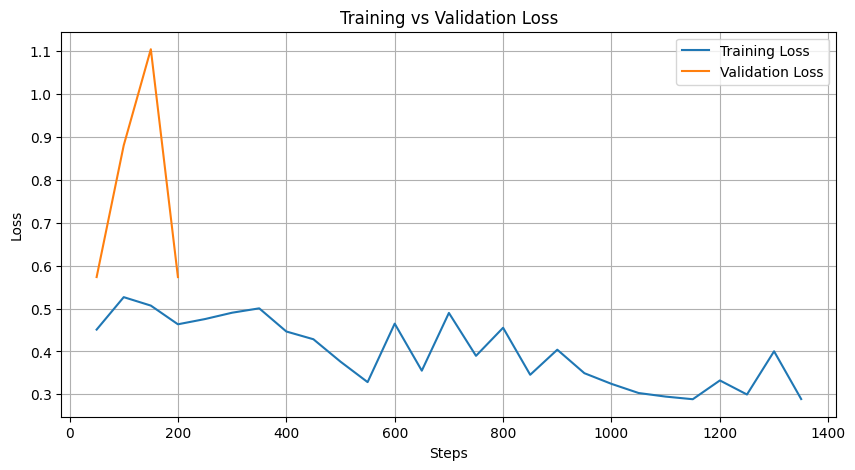

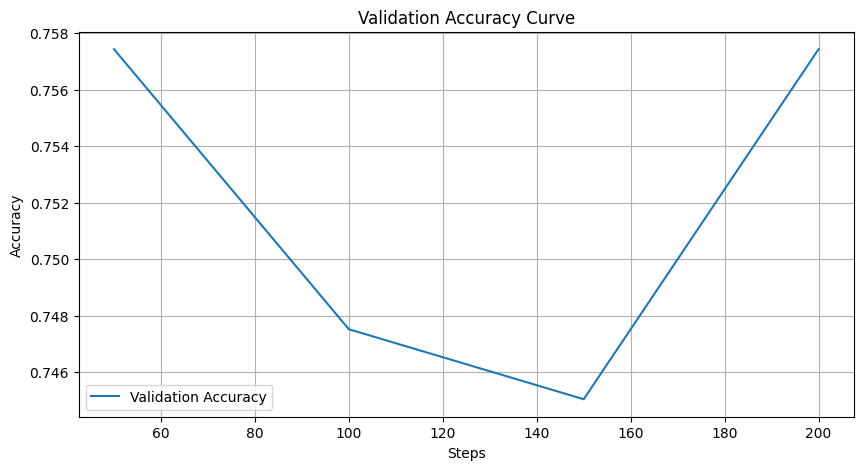

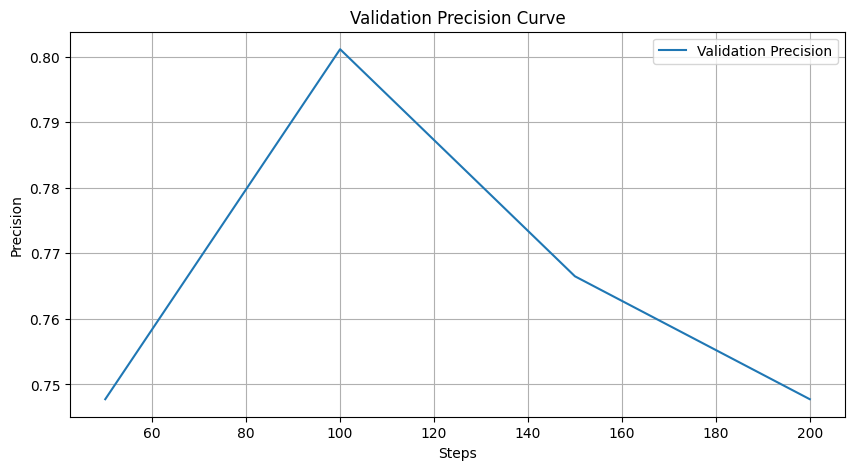

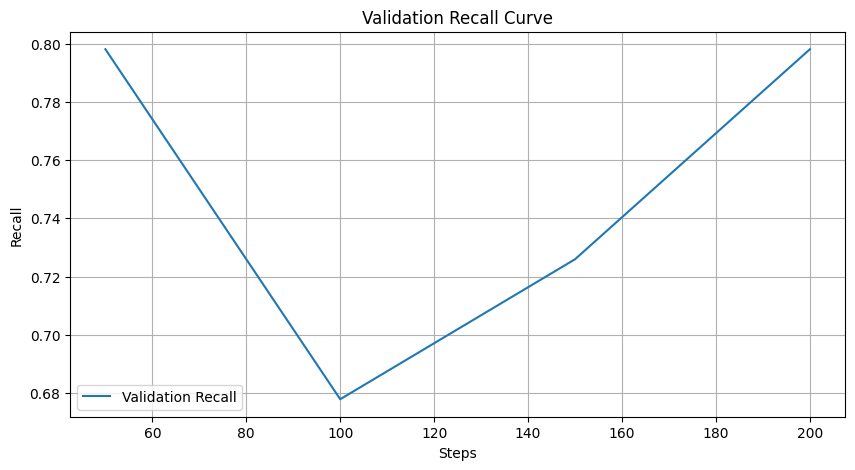

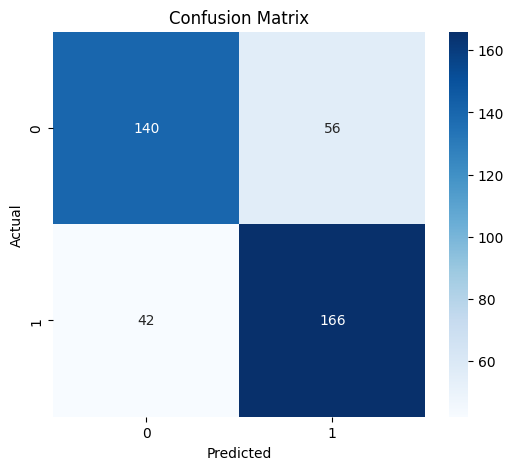

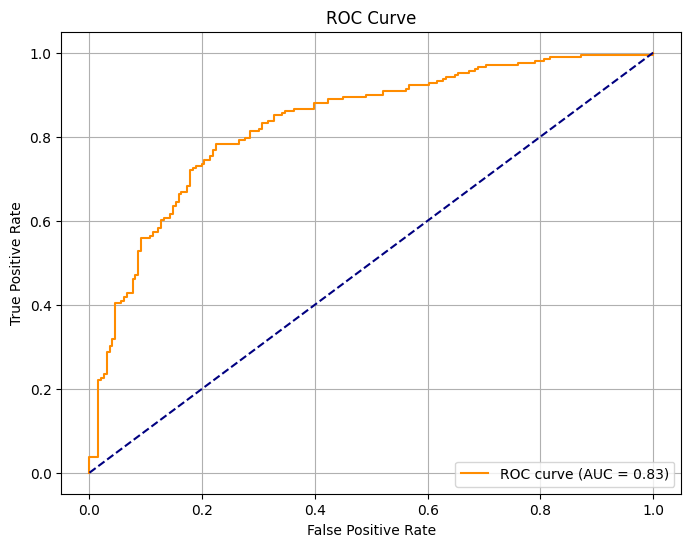

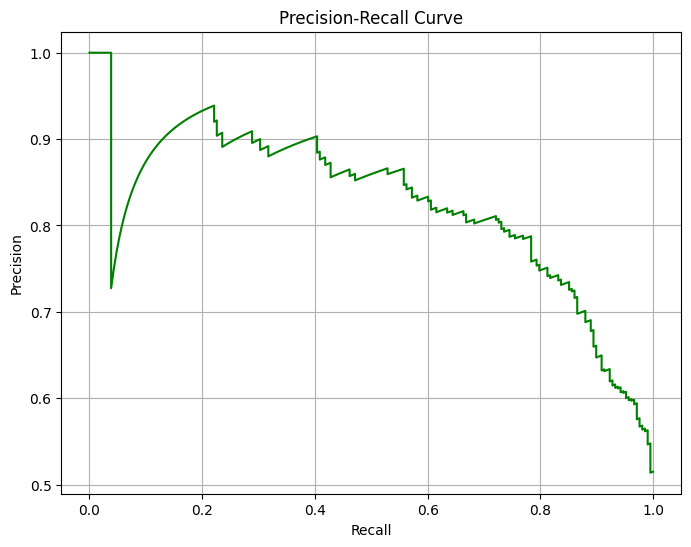

In [45]:
log_history = trainer.state.log_history

train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
steps = []

for entry in log_history:
    if "loss" in entry:
        train_losses.append(entry["loss"])
        steps.append(entry["step"])
    if "eval_loss" in entry:
        val_losses.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        val_accuracies.append(entry["eval_accuracy"])
    if "eval_precision" in entry:
        val_precisions.append(entry["eval_precision"])
    if "eval_recall" in entry:
        val_recalls.append(entry["eval_recall"])

plt.figure(figsize=(10,5))
plt.plot(steps[:len(train_losses)], train_losses, label="Training Loss")
plt.plot(steps[:len(val_losses)], val_losses, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(steps[:len(val_accuracies)], val_accuracies, label="Validation Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(steps[:len(val_precisions)], val_precisions, label="Validation Precision")
plt.xlabel("Steps")
plt.ylabel("Precision")
plt.title("Validation Precision Curve")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(steps[:len(val_recalls)], val_recalls, label="Validation Recall")
plt.xlabel("Steps")
plt.ylabel("Recall")
plt.title("Validation Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

def get_predictions(model, dataset):
    model.eval()
    preds = []
    labels = []
    loader = DataLoader(dataset, batch_size=16)
    with torch.no_grad():
        for batch in loader:
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            pred = torch.argmax(outputs.logits, dim=1)
            preds.extend(pred.tolist())
            labels.extend(batch["labels"].tolist())
    return labels, preds

true_labels, pred_labels = get_predictions(model, val_dataset)

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc, precision_recall_curve

probs = []
labels_list = []
model.eval()
loader = DataLoader(val_dataset, batch_size=16)
with torch.no_grad():
    for batch in loader:
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )
        prob = torch.softmax(outputs.logits, dim=1)[:,1]
        probs.extend(prob.tolist())
        labels_list.extend(batch["labels"].tolist())

fpr, tpr, _ = roc_curve(labels_list, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

precision, recall, _ = precision_recall_curve(labels_list, probs)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

metrics_data = {
    "train_loss": train_losses,
    "val_loss": val_losses,
    "val_accuracy": val_accuracies,
    "val_precision": val_precisions,
    "val_recall": val_recalls,
    "confusion_matrix": cm.tolist()
}

with open("training_metrics.json", "w") as f:
    json.dump(metrics_data, f, indent=4)